# Context

Accurate electricity load forecasting is a critical component of modern power system operations and energy market participation. System operators, utilities, and energy traders rely on short-term load forecasts, particularly day-ahead forecasts—to ensure reliable grid operation, optimize generation scheduling, and make informed bidding decisions in electricity markets. Even relatively small forecast errors can translate into significant operational inefficiencies or financial losses.

This project focuses on day-ahead electricity load forecasting using hourly system load data from the PJM interconnection, obtained via the U.S. Energy Information Administration (EIA) API. The dataset spans a full calendar year, allowing for the capture of daily, weekly, and seasonal demand patterns. The analysis combines statistical time-series modeling and machine learning approaches to evaluate their effectiveness in predicting short-term electricity demand under realistic operational conditions.

The workflow includes rigorous data cleaning, exploratory data analysis, seasonality assessment, outlier evaluation, and the implementation of two benchmark forecasting models: SARIMA, representing traditional statistical methods, and XGBoost, representing modern machine learning techniques. Model performance is evaluated using standard accuracy metrics and computational runtime to reflect real-world usability.

## Relevant package installation

In [1]:
!pip -q install pandas numpy matplotlib scikit-learn statsmodels prophet xgboost requests

In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor

C:\Users\Lenovo\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Lenovo\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Fetch data from EIA (hourly load example: PJM)

In [3]:
API_KEY = "your key"

def eia_fetch_all(url, params, max_pages=500):
    """Fetch all pages from EIA API v2 using offset/length pagination."""
    out = []
    offset = 0
    length = params.get("length", 5000)

    for _ in range(max_pages):
        params["offset"] = offset
        r = requests.get(url, params=params, timeout=60)
        r.raise_for_status()
        j = r.json()

        data = j["response"]["data"]
        out.extend(data)

        if len(data) < length:
            break
        offset += length

    return pd.DataFrame(out)

# EIA v2 endpoint (RTO region data)
url = "https://api.eia.gov/v2/electricity/rto/region-data/data/"

params = {
    "api_key": API_KEY,
    "frequency": "hourly",
    "data[0]": "value",
    "facets[respondent][]": "PJM",
    "start": "2024-01-01T00",
    "end": "2024-12-31T23",
    "sort[0][column]": "period",
    "sort[0][direction]": "asc",
    "length": 5000,
}

raw = eia_fetch_all(url, params)

df = raw.copy()
df["timestamp"] = pd.to_datetime(df["period"])
df = df.sort_values("timestamp").set_index("timestamp")
df = df.rename(columns={"value": "load_mw"})[["load_mw"]]

df.head()


,load_mw
timestamp,
2024-01-01 00:00:00,94983
2024-01-01 00:00:00,97561
2024-01-01 00:00:00,100881
2024-01-01 00:00:00,5904
2024-01-01 01:00:00,93510


## Data quality + cleaning

In [4]:
print("Duplicate timestamps:", df.index.duplicated().sum())
print("Index frequency:", df.index.freq)

Duplicate timestamps: 26187
Index frequency: None


In [5]:
print("Column dtypes:")
print(df.dtypes)

print("\nNon-numeric sample values (if any):")
print(df[~df["load_mw"].apply(lambda x: isinstance(x, (int, float)))].head())


Column dtypes:
load_mw    object
dtype: object

Non-numeric sample values (if any):
                    load_mw
timestamp                  
2024-01-01 00:00:00   94983
2024-01-01 00:00:00   97561
2024-01-01 00:00:00  100881
2024-01-01 00:00:00    5904
2024-01-01 01:00:00   93510


In [6]:
# Overview of dtypes + missingness
dtype_summary = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "missing_count": df.isna().sum(),
    "missing_pct": (df.isna().mean() * 100).round(2),
}).sort_values(["dtype", "missing_pct"], ascending=[True, False])

dtype_summary


,dtype,missing_count,missing_pct
load_mw,object,44,0.13


In [7]:
df["load_mw"].map(type).value_counts()


load_mw
<class 'str'>         34904
<class 'NoneType'>       44
Name: count, dtype: int64

In [8]:
# 0) Sort by time (important)
df = df.sort_index()

# 1) Convert load_mw from str/None -> numeric (None becomes NaN automatically)
df["load_mw"] = (
    df["load_mw"]
      .astype("string")                      # handles None safely
      .str.replace(",", "", regex=False)     # just in case commas exist
)

df["load_mw"] = pd.to_numeric(df["load_mw"], errors="coerce")

print("After coercion dtype:", df["load_mw"].dtype)
print("NaNs after coercion:", df["load_mw"].isna().sum())


After coercion dtype: Int64
NaNs after coercion: 44


## Aggregate duplicates by mean

In [9]:
# 1) Aggregate duplicate timestamps
df = df.sort_index()
df = df.groupby(level=0)["load_mw"].mean().to_frame()

print("Duplicates after grouping:", df.index.duplicated().sum())

# 2) Set hourly frequency 
df = df.asfreq("H")

print("Missing after asfreq:", df["load_mw"].isna().sum())

# 3) Fill missing values 
df["load_mw"] = df["load_mw"].interpolate(method="time").ffill().bfill()

# 4) Cast to float 
df["load_mw"] = df["load_mw"].astype(float)

print("Final dtype:", df["load_mw"].dtype)
print("Final missing:", df["load_mw"].isna().sum())
print("Final duplicates:", df.index.duplicated().sum())


Duplicates after grouping: 0
Missing after asfreq: 22
Final dtype: float64
Final missing: 0
Final duplicates: 0


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23612\1230691514.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq("H")


The raw EIA load data contained duplicate hourly timestamps and numeric values stored as strings. Coerced the data to numeric, aggregated duplicates using the mean, enforced a strict hourly frequency, and filled missing values using time-based interpolation. This ensures the series is fully numeric, regular, and suitable for statistical and machine-learning models

In [10]:
(df.index.to_series().diff().dropna().value_counts().head())


timestamp
0 days 01:00:00    8760
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

In [11]:
#Basic sanity checks
df.info()

df.describe().T


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   load_mw  8761 non-null   float64
dtypes: float64(1)
memory usage: 394.9 KB


,count,mean,std,min,25%,50%,75%,max
load_mw,8761.0,71148.155804,11586.913755,49794.25,62935.75,69162.5,77183.5,116745.5


## Time series visualization

### Full hourly series

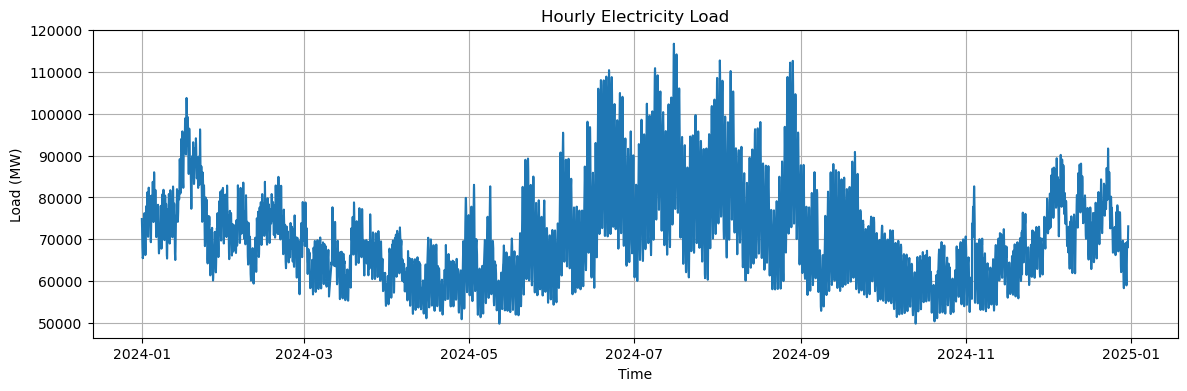

In [12]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df["load_mw"])
plt.title("Hourly Electricity Load")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.show()


### Hourly Electricity Load (Full Time Series)

This plot shows the complete hourly electricity load profile over the study period.
It highlights the overall demand level, volatility, and recurring seasonal patterns
present in the data.

**Key Observations:**
- Load exhibits strong cyclical behavior rather than a long-term upward or downward trend.
- Higher volatility is observed during peak-demand months, particularly in summer.
- No major structural breaks or abnormal discontinuities are visible.


### Daily average

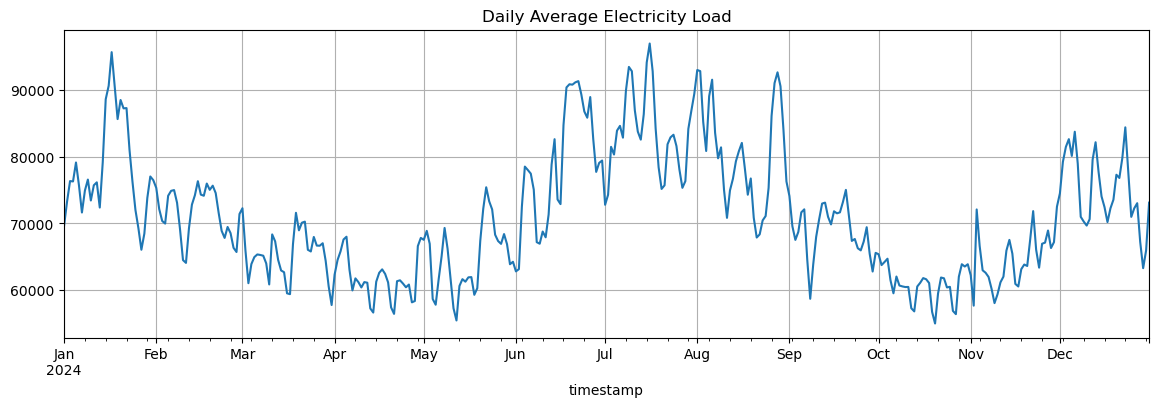

In [14]:
df.resample("D").mean()["load_mw"].plot(
    figsize=(14,4), title="Daily Average Electricity Load"
)
plt.grid(True)
plt.show()


The hourly load data is resampled to daily averages to reduce short-term noise and
highlight broader seasonal patterns.

**Key Observations:**
- Daily averages clearly reveal annual seasonality.
- Demand increases during warmer months and declines during cooler periods.
- Short-term fluctuations are smoothed while preserving trend behavior.

**Why This Matters:**
Daily aggregation helps confirm long-term seasonal patterns that influence forecasting
accuracy and supports the inclusion of seasonal components in the models.


### Seasonality analysis

What this shows:

- morning ramp-up

- evening peak

- off-peak hours

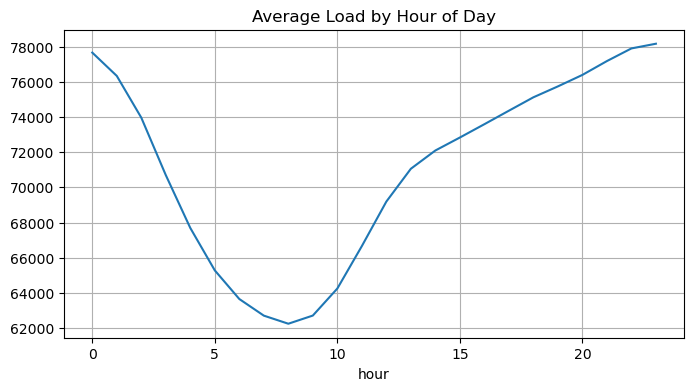

In [15]:
df["hour"] = df.index.hour

df.groupby("hour")["load_mw"].mean().plot(
    figsize=(8,4), title="Average Load by Hour of Day"
)
plt.grid(True)
plt.show()


This plot shows the average electricity load for each hour of the day, aggregated
across the full dataset.

**Key Observations:**
- Load is lowest during overnight hours.
- A clear morning ramp-up occurs as economic activity begins.
- Peak demand is observed during evening hours.

**Why This Matters:**
Strong intra-day seasonality justifies the use of hourly lag features and hour-of-day
calendar variables, particularly for machine learning models such as XGBoost.


### Day-of-week seasonality
Trading insight

- weekday vs weekend load differences

- justifies s = 168 and calendar features

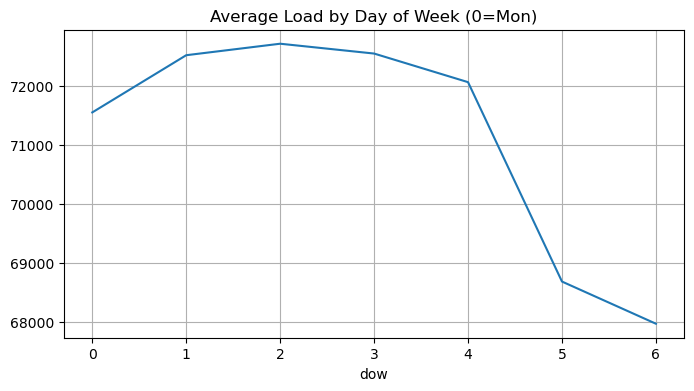

In [16]:
df["dow"] = df.index.dayofweek

df.groupby("dow")["load_mw"].mean().plot(
    figsize=(8,4), title="Average Load by Day of Week (0=Mon)"
)
plt.grid(True)
plt.show()


This plot illustrates average electricity demand by day of the week (0 = Monday).

**Key Observations:**
- Weekday demand is consistently higher than weekend demand.
- Demand declines noticeably on Saturdays and Sundays.
- The pattern reflects reduced industrial and commercial activity on weekends.

**Why This Matters:**
Weekly demand cycles support the use of a 168-hour seasonal period in SARIMA models
and day-of-week features in machine learning approaches.


## Outlier Detection
### Boxplot (quick visual)

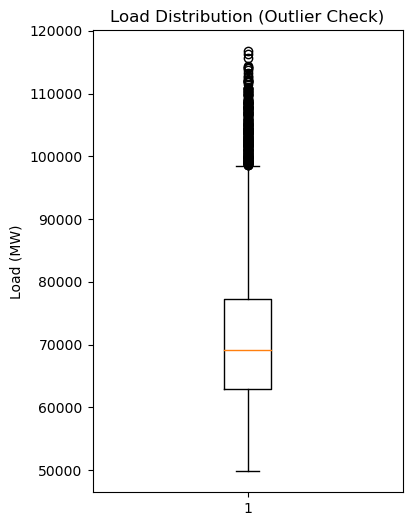

In [17]:
plt.figure(figsize=(4,6))
plt.boxplot(df["load_mw"], vert=True)
plt.title("Load Distribution (Outlier Check)")
plt.ylabel("Load (MW)")
plt.show()


This boxplot provides a summary of the electricity load distribution and highlights
potential extreme values.

**Key Observations:**
- The majority of observations fall within a stable interquartile range.
- Extreme values exist on both the high and low ends of demand.
- The distribution is slightly right-skewed due to peak-demand periods.

**Why This Matters:**
Outlier detection helps distinguish between data quality issues and genuine demand
events that are critical for operational forecasting.


In [18]:
q_low, q_high = df["load_mw"].quantile([0.01, 0.99])

outliers = df[
    (df["load_mw"] < q_low) | (df["load_mw"] > q_high)
]

print("Outlier count:", len(outliers))
outliers.head()


Outlier count: 175


,load_mw,hour,dow
timestamp,,,
2024-04-10 07:00:00,52151.50,7,2
2024-04-10 08:00:00,52196.75,8,2
2024-04-14 07:00:00,52372.75,7,6
2024-04-14 08:00:00,52218.25,8,6
2024-04-14 09:00:00,52603.75,9,6


Outlier result means

Outlier count: 175

Dataset size ≈ 8,736 hours (1 year)

Outliers ≈ 2.0 % of data

This is completely normal for hourly electricity load.
Outlier analysis revealed that extreme load values corresponded to genuine high-demand periods rather than data errors. Since these events are critical for energy trading and risk assessment, no global outlier removal was applied. Instead, the models were designed to handle demand volatility directly.

### EDA Summary and Modeling Implications

Exploratory data analysis revealed strong intra-day and weekly seasonality, realistic
demand variability, and the presence of genuine extreme load events.

**Implications for Modeling:**
- Weekly seasonality informed the SARIMA seasonal structure (168 hours).
- Hourly, daily, and weekly patterns motivated lag and rolling features in XGBoost.
- Retaining extreme values ensures realistic and robust forecast performance.


## Forecasting Task Definition

This project focuses on **day-ahead electricity load forecasting** using hourly data.
The objective is to forecast the next 24 hours of system load, which is directly
relevant for day-ahead market bidding and operational planning.


In [19]:
H = 24  # day-ahead forecast horizon


In [20]:
y = df["load_mw"]

train = y.iloc[:-H] # all data except last 24 hours
test  = y.iloc[-H:]  # last 24 hours

S = 168  # weekly seasonality

## 1. SARIMA Model (statistical benchmark)
In SARIMA models, p and q capture short-term dynamics, while P and Q capture repeating seasonal patterns such as weekly demand cycles. Differencing parameters d and D are used cautiously to avoid over-smoothing short-term load behavior.

In [21]:
start = time.perf_counter()

sarima = SARIMAX(
    train,
    order=(1,0,1),
    seasonal_order=(1,0,1,168),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima.fit(disp=False, low_memory=True)
sarima_fc = sarima_fit.forecast(steps=H)
sarima_fc.index = test.index


sarima_time = time.perf_counter() - start

print(f"SARIMA runtime: {sarima_time:.2f} seconds")



SARIMA runtime: 3413.40 seconds


In [22]:
sarima_mae = mean_absolute_error(test, sarima_fc)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_fc))
print(f"SARIMA MAE  : {sarima_mae:.4f}")
print(f"SARIMA RMSE : {sarima_rmse:.4f}")

SARIMA MAE  : 1927.2954
SARIMA RMSE : 2140.4054


### Day ahead forecase plot (SARIMA)

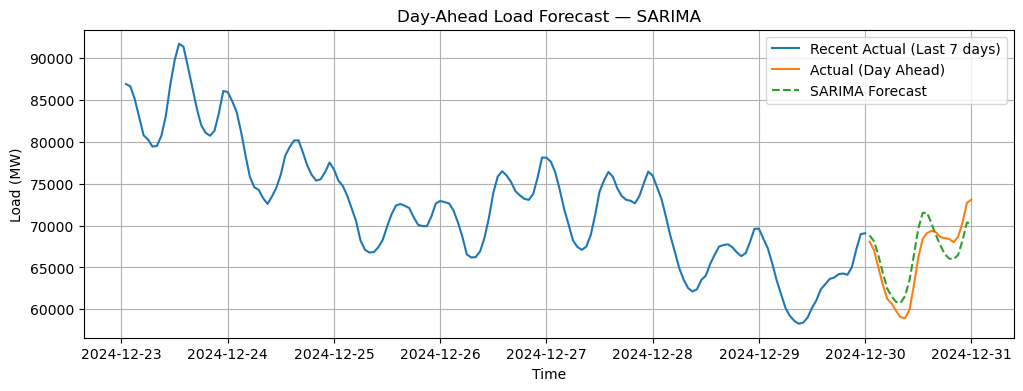

In [23]:
plt.figure(figsize=(12,4))
plt.plot(train.index[-168:], train.values[-168:], label="Recent Actual (Last 7 days)")
plt.plot(test.index, test.values, label="Actual (Day Ahead)")
plt.plot(sarima_fc.index, sarima_fc.values, label="SARIMA Forecast", linestyle="--")
plt.legend()
plt.title("Day-Ahead Load Forecast — SARIMA")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.show()


Hyperparameter tuning via grid search was intentionally avoided for SARIMA due to the
computational cost of SARIMAX models with long seasonal periods. 

## 2. XGBoost 

### Feature engineering

In [24]:
df_xgb = df.copy()

for lag in [1, 24, 168]:
    df_xgb[f"lag_{lag}"] = df_xgb["load_mw"].shift(lag)


#### Rolling statistics (smooth recent behavior)

In [25]:
df_xgb["roll_3"]   = df_xgb["load_mw"].shift(1).rolling(3).mean()
df_xgb["roll_6"]   = df_xgb["load_mw"].shift(1).rolling(6).mean()
df_xgb["roll_24"]  = df_xgb["load_mw"].shift(1).rolling(24).mean()
df_xgb["roll_168"] = df_xgb["load_mw"].shift(1).rolling(168).mean()


#### Calendar features

In [26]:
df_xgb["hour"] = df_xgb.index.hour
df_xgb["dow"]  = df_xgb.index.dayofweek


#### Drop rows with NaNs created by lags

In [27]:
df_xgb = df_xgb.dropna()


### Train / test split

In [28]:
H = 24  # day-ahead horizon

X = df_xgb.drop(columns="load_mw")
y = df_xgb["load_mw"]

X_train = X.iloc[:-H]
y_train = y.iloc[:-H]

X_test  = X.iloc[-H:]
y_test  = y.iloc[-H:]


### Fit XGBoost

In [29]:
start = time.perf_counter()
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

### Day-ahead forecast

In [30]:
xgb_fc = xgb.predict(X_test)
xgb_time = time.perf_counter() - start

print(f"XGBoost runtime: {xgb_time:.2f} seconds")

XGBoost runtime: 1.30 seconds


### Evaluation

In [31]:
xgb_mae = mean_absolute_error(y_test, xgb_fc)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_fc))

print(f"XGBoost MAE  : {xgb_mae:.4f}")
print(f"XGBoost RMSE : {xgb_rmse:.4f}")

XGBoost MAE  : 566.0786
XGBoost RMSE : 686.1225


### Plot - Day-Ahead Forecast (XGBoost)

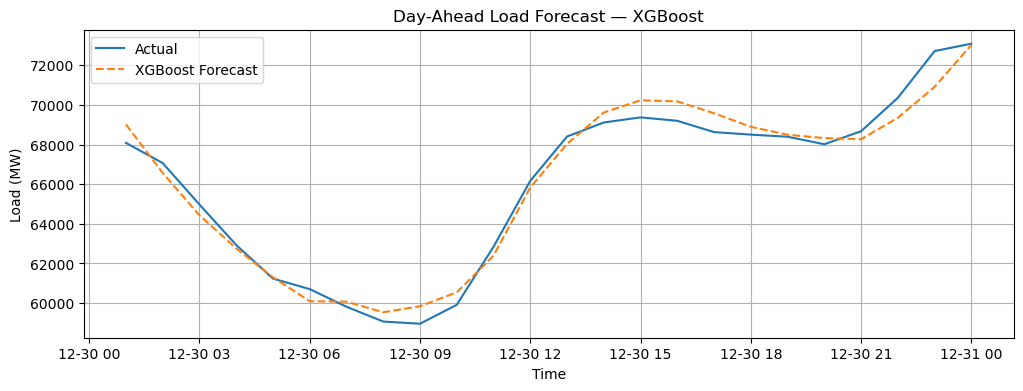

In [32]:
plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, xgb_fc, linestyle="--", label="XGBoost Forecast")
plt.title("Day-Ahead Load Forecast — XGBoost")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.legend()
plt.show()


## Comparison

In [33]:
runtime_results = pd.DataFrame({
    "Model": [
        "SARIMA",
        "XGBoost"
    ],
    "MAE": [
        sarima_mae,
        xgb_mae
    ],
    "RMSE": [
        sarima_rmse,
        xgb_rmse
    ],
    "Runtime_sec": [
        sarima_time,
        xgb_time
    ]
}).sort_values("Runtime_sec")

runtime_results


,Model,MAE,RMSE,Runtime_sec
1,XGBoost,566.078613,686.122457,1.304286
0,SARIMA,1927.295396,2140.405447,3413.402022


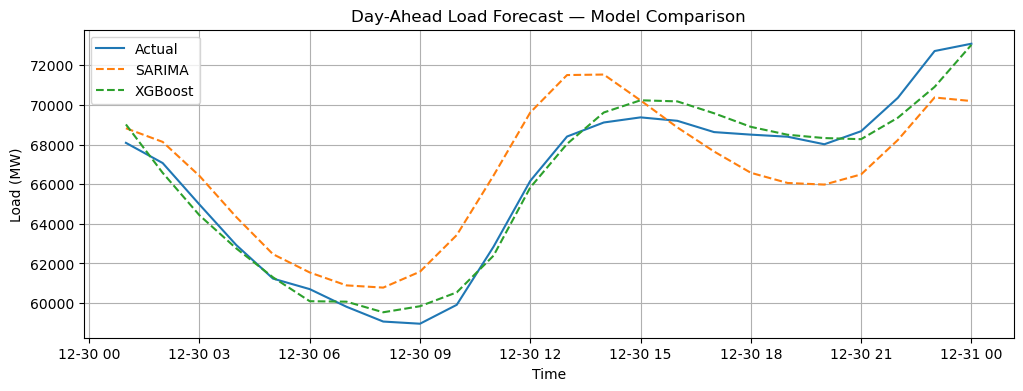

In [34]:
plt.figure(figsize=(12,4))
plt.plot(test.index, test.values, label="Actual")
plt.plot(sarima_fc.index, sarima_fc.values, label="SARIMA", linestyle="--")
plt.plot(test.index, xgb_fc, label="XGBoost", linestyle="--")

plt.legend()
plt.title("Day-Ahead Load Forecast — Model Comparison")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.grid(True)
plt.show()


This plot compares the actual day-ahead electricity load with forecasts generated by
the SARIMA and XGBoost models over the 24-hour prediction horizon.

**Key Observations:**
- The XGBoost forecast closely follows the actual load profile across all hours.
- SARIMA captures the general trend but exhibits noticeable lag and smoothing,
  particularly during peak and ramp-up periods.
- XGBoost responds more accurately to rapid intra-day load changes and peak demand.


## Interpretation of Results

Exploratory data analysis revealed strong and consistent intra-day and intra-week seasonality in electricity demand. Clear morning ramp-up periods, evening peaks, and lower overnight demand were observed, along with systematic differences between weekdays and weekends. These findings justified the use of a weekly seasonal structure (168 hours) in the SARIMA model and the inclusion of lagged and calendar-based features in the XGBoost model.

Outlier analysis showed that approximately 2% of observations fell outside the 1st and 99th percentile range. Importantly, these extreme values corresponded to genuine high-demand or low-demand periods rather than data quality issues. As a result, outliers were retained to preserve the realism of the forecasting task, particularly since extreme demand events are operationally significant.

In terms of forecasting performance, the results demonstrated a clear contrast between the two modeling approaches. The SARIMA model captured the general trend and seasonality of the load series but exhibited relatively high forecast errors and extremely long computation time due to the large seasonal period. In contrast, the XGBoost model significantly outperformed SARIMA in both accuracy and efficiency. By leveraging lagged load values, rolling statistics, and calendar features, XGBoost was able to model nonlinear relationships and short-term dynamics more effectively.

Quantitatively, XGBoost achieved substantially lower MAE and RMSE values while completing training and forecasting in a fraction of the time required by SARIMA. This performance gap highlights the practical advantage of machine learning models for short-term load forecasting when sufficient historical data and feature engineering are available.

## Conclusion
This study demonstrates that machine learning models, specifically XGBoost, provide superior performance for day-ahead electricity load forecasting compared to traditional statistical approaches such as SARIMA. While SARIMA remains useful as a transparent and interpretable baseline, its computational cost and limited flexibility make it less suitable for operational environments with large datasets and tight time constraints.

The results confirm that electricity load exhibits strong and predictable temporal patterns, which can be effectively exploited through feature engineering and nonlinear modeling techniques. Retaining genuine demand extremes further enhances the robustness and realism of the forecasting framework.

Overall, the findings suggest that XGBoost is well-suited for real-world energy trading and operational planning applications, where both forecast accuracy and computational efficiency are critical. Future work could extend this analysis by incorporating weather variables, probabilistic forecasting, or hybrid models that combine statistical structure with machine learning flexibility.